In [21]:
from sklearn.datasets import fetch_covtype

import sys
sys.path.append("..")
from divexp import *

import numpy as np
np.float = float
from skmultiflow.data import ConceptDriftStream, AGRAWALGenerator, LEDGenerator

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import KBinsDiscretizer
import pandas as pd
from detect import *


In [44]:
class NoisyLEDGenerator(LEDGenerator):
    def __init__(self, drift_from=None, drift_extent=0.1, *args, **kwargs):
        super().__init__(*args, **kwargs)

        if drift_from is None:
            self.config = self._random_state.random(self.n_features)
        else:
            self._random_state.random(self.n_features)
            noise = self._random_state.uniform(-drift_extent, +drift_extent, size=self.n_features)
            self.config = drift_from.config + noise

    
    def next_sample(self, *args, **kwargs):
        X, y = super().next_sample(*args, **kwargs)

        flips = np.random.random(X.shape)

        to_flip = flips < self.config

        X[to_flip] = 1 - X[to_flip]
        return X, y

In [45]:
class SEAWrapper:
    def __init__(self, random_state, noise_percentage=0.0):
        self.stream=SEAGenerator(balance_classes=False, classification_function=2, noise_percentage=noise_percentage, random_state=random_state)
        self.drift_stream=SEAGenerator(balance_classes=False, classification_function=3, noise_percentage=noise_percentage, random_state=random_state)
        self.kb = KBinsDiscretizer(encode="onehot-dense", n_bins=5, strategy="uniform")
        self.kb_fit = False
    
    def get_metadata(self, X):
        features = ["a","b","c"]

        if not self.kb_fit:
            X_bin = self.kb.fit_transform(X).astype(bool)
            self.kb_fit = True
        else:
            X_bin = self.kb.transform(X).astype(bool)
        return pd.DataFrame(data=X_bin, columns=self.kb.get_feature_names_out(input_features=features))


class AgrawalWrapper:
    def __init__(self, random_state=None, perturbation=0.0):
        self.stream=AGRAWALGenerator(balance_classes=False, classification_function=0, perturbation=perturbation, random_state=random_state)
        self.drift_stream=AGRAWALGenerator(balance_classes=False, classification_function=2, perturbation=perturbation, random_state=random_state+1)
        self.kb = KBinsDiscretizer(encode="onehot-dense", n_bins=5, strategy="uniform")
        self.kb_fit = False
    
    def get_metadata(self, X):
        features = ["salary",
            "commission",
            "age",
            "elevel",
            "car",
            "zipcode",
            "hvalue",
            "hyears",
            "loan"]

        if not self.kb_fit:
            X_bin = self.kb.fit_transform(X).astype(bool)
            self.kb_fit = True
        else:
            X_bin = self.kb.transform(X).astype(bool)
        return pd.DataFrame(data=X_bin, columns=self.kb.get_feature_names_out(input_features=features))

class LEDWrapper:
    def __init__(self, random_state, bounded_drift=False, noise_percentage=0.0):
        self.stream = NoisyLEDGenerator(random_state=random_state, noise_percentage=noise_percentage)
        if bounded_drift:
            self.drift_stream = NoisyLEDGenerator(drift_from=self.stream,
                                                  drift_extent=bounded_drift,
                                                  random_state=random_state+1,
                                                  noise_percentage=noise_percentage
            )
        else:
            self.drift_stream = NoisyLEDGenerator(random_state=random_state+1, noise_percentage=noise_percentage)
        self.n_features = self.stream.n_features
    
    def get_metadata(self, X):
        return pd.DataFrame(data=X.astype(bool), columns=[f"feature {i}" for i in range(self.n_features)])

class RBFWrapper:
    def __init__(self, random_state, **kwargs):
        self.stream = RandomRBFGenerator(model_random_state=random_state, **kwargs)
        self.drift_stream = RandomRBFGenerator(model_random_state=random_state+1, **kwargs)
        self.kb = KBinsDiscretizer(encode="onehot-dense", n_bins=5, strategy="uniform")
        self.kb_fit = False
    
    def get_metadata(self, X):
        if not self.kb_fit:
            X_bin = self.kb.fit_transform(X).astype(bool)
            self.kb_fit = True
        else:
            X_bin = self.kb.transform(X).astype(bool)
        return pd.DataFrame(data=X_bin, columns=self.kb.get_feature_names_out())




In [46]:
from skmultiflow.data import RandomRBFGeneratorDrift, RandomRBFGenerator, SEAGenerator

In [47]:
def train_and_drift(DataSource, drift=True, ds_kwargs={}, train_size=5_000, n_batches=50, batch_size=200, ClfModel=DecisionTreeClassifier, clf_kwargs={}):
    tot_samples = n_batches * batch_size # total number of samples
    position = (n_batches // 2) * batch_size # "center" of the drift
    width = (n_batches // 4) * batch_size # size of the transitory

    data_source = DataSource(**ds_kwargs)
    stream = data_source.stream
    drift_stream = data_source.drift_stream

    if drift:
        cds = ConceptDriftStream(stream=stream, drift_stream=drift_stream, position=position, width=width)
    else:
        cds = ConceptDriftStream(stream=stream, drift_stream=stream, position=position, width=width) # no drift!

    X_train, y_train = stream.next_sample(train_size)

    clf = ClfModel(**clf_kwargs)
    clf.fit(X_train, y_train)
    
    df_meta = data_source.get_metadata(X_train)
    matches = compute_matches(df_meta, minsup=0.1)

    divs = []
    matches_ts_list = []
    accuracies = []

    # for other detection methods
    # for i in range(tot_samples):
    #     x_batch, y_batch = cds.next_sample()
    #     y_pred = clf.predict(x_batch)
    #     drift_detector_method.add(y_pred == y_batch)

    for start_ndx in range(0, tot_samples, batch_size):
        X_batch, y_batch = cds.next_sample(batch_size)
        
        y_pred = clf.predict(X_batch)

        # Workaround for multi-class problems -- works with accuracy!
        y_pred = y_batch == y_pred
        y_batch = np.ones(len(y_batch))

        accuracies.append(accuracy_score(y_batch, y_pred))

        df_batch_bin = data_source.get_metadata(X_batch)
        matches_ts = compute_matches(df_batch_bin, fi=matches.fi)
        matches_ts = Matches(matches=matches_ts.matches.astype(int), fi=matches.fi)

        divs.append(div_explorer(matches_ts, y_batch, y_pred, ['accuracy']))
        matches_ts_list.append(matches_ts)

    delta, t_stat = detect_singlebatch(divs, 'accuracy', (0,5), (45,50))

    return delta.min(), t_stat.max()

In [78]:
n_exp = 100
train_size = 5_000

n_batches = 50
batch_size=200

tstats = np.empty(n_exp)
deltas = np.empty(n_exp)
gt = np.empty(n_exp)

exp_type = "led"

if exp_type == "agrawal":
    DataClass = AgrawalWrapper
    data_kwargs = {"perturbation": 0.5}
if exp_type == "sea":
    DataClass = SEAWrapper
    data_kwargs = {"noise_percentage": 0.4}
elif exp_type == "led":
    DataClass = LEDWrapper
    data_kwargs = {"bounded_drift": 0.25, "noise_percentage": 0.1}
elif exp_type == "rbf":
    DataClass = RBFWrapper
    data_kwargs = {}

i = 0
for drift in [True, False]:
    for exp in range(n_exp//2): # positive samples

        delta, tstat = train_and_drift(DataClass,
                                       ds_kwargs={ "random_state": i, **data_kwargs },
                                       drift=drift,
                                       train_size=train_size,
                                       n_batches=n_batches,
                                       batch_size=batch_size,
                                       ClfModel=DecisionTreeClassifier,
                                       clf_kwargs={}
        )

        deltas[i] = delta
        tstats[i] = tstat
        gt[i] = drift
        print(exp, drift, tstats[i], deltas[i])
        
        i += 1


0 True 3.6220727059105 -0.17094017094017094
1 True 3.0459501027319402 -0.09214941716707878
2 True 2.5133413490875425 -0.05807423640597176
3 True 4.413226667494969 -0.21671826625386997
4 True 5.953289755667476 -0.28446852425180597
5 True 3.226020140947122 -0.16096009253903992
6 True 7.027910248023945 -0.3139596602972399
7 True 2.7350670196241795 -0.08079125455491931
8 True 7.145703832311698 -0.3332561371005095
9 True 5.708247393398797 -0.1943290402991275
10 True 3.86606586221984 -0.20367005813953487
11 True 5.510516658136416 -0.1844326004885632
12 True 2.85553944239978 -0.1576190476190476
13 True 4.619855169550239 -0.22067448680351903
14 True 4.873599960887386 -0.2135497529992943
15 True 2.6450981616275886 -0.10702772404900066
16 True 3.0981361755758767 -0.16555407209612816
17 True 4.703324312603157 -0.1142263759086189
18 True 3.404323814722913 -0.10027472527472525
19 True 4.132055890420066 -0.04113809351214204
20 True 4.603816683924325 -0.22393442622950827
21 True 2.7892899369120876 -0

0.1459612659423713


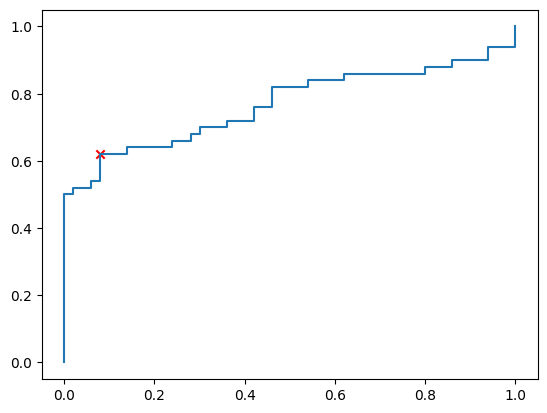

In [80]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

fpr, tpr, thresh = roc_curve(gt, -deltas)
plt.plot(fpr, tpr)

best_thresh = thresh[(tpr - fpr).argmax()]
print(best_thresh)
plt.scatter([fpr[(tpr - fpr).argmax()]], [tpr[(tpr - fpr).argmax()]], marker='x', c='r')

2.950096356612971


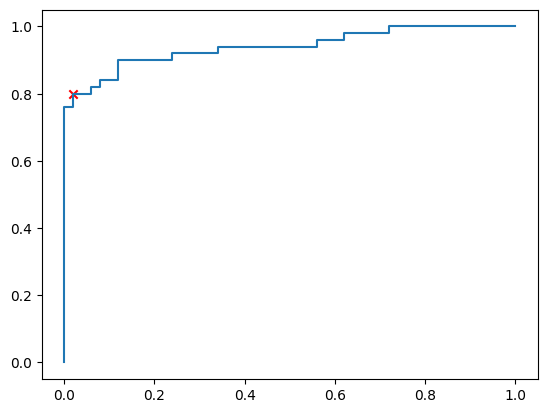

In [81]:
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score

fpr, tpr, thresh = roc_curve(gt, tstats)
plt.plot(fpr, tpr)

best_thresh = thresh[(tpr - fpr).argmax()]
print(best_thresh)
plt.scatter([fpr[(tpr - fpr).argmax()]], [tpr[(tpr - fpr).argmax()]], marker='x', c='r')

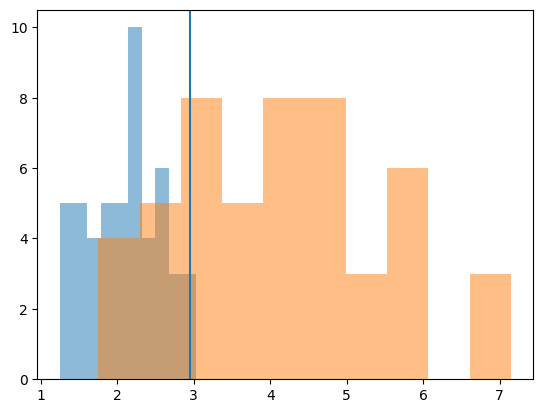

In [82]:
import matplotlib.pyplot as plt

plt.hist(tstats[gt==0], alpha=.5, label="Negative t-stats")
plt.hist(tstats[gt==1], alpha=.5, label="Positive t-stats")
plt.axvline(best_thresh)

In [83]:
y_pred = np.array(tstats) >= best_thresh

print("accuracy", accuracy_score(gt, y_pred))
print("f1 score", f1_score(gt, y_pred))

from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(gt, y_pred).ravel()

print("fpr", fp / (fp + tn))
print("fnr", fn / (fn + tp))

accuracy 0.89
f1 score 0.8791208791208791
fpr 0.02
fnr 0.2


In [88]:
import pandas as pd

def train_and_drift_insect(insect_type, train_size=5_000, batch_size=200, ClfModel=DecisionTreeClassifier, clf_kwargs={}):

    known = {
        "abrupt": "INSECTS-abrupt_balanced_norm.csv",
        "gradual": "INSECTS-gradual_balanced_norm.csv",
        "incremental": "INSECTS-incremental_balanced_norm.csv"
    }
    if insect_type not in known:
        raise Exception("Unknown", insect_type)

    df = pd.read_csv(known[insect_type])

    tot_samples = len(df)

    X = df.values[:, :-1]
    y = df.values[:, -1]

    X_train = X[:train_size]
    y_train = y[:train_size]

    clf = ClfModel(**clf_kwargs)
    clf.fit(X_train, y_train)

    kb = KBinsDiscretizer(n_bins=5, encode="onehot-dense")
    df_meta = pd.DataFrame(kb.fit_transform(X_train).astype(bool), columns=kb.get_feature_names_out())
    matches = compute_matches(df_meta, minsup=0.1)
    print("Itemsets", len(matches.fi))

    divs = []
    matches_ts_list = []
    accuracies = []

    deltas = []
    tstats = []

    win_size = 5
    most_div = []

    for start_ndx in range(train_size, tot_samples, batch_size):
        # X_batch, y_batch = cds.next_sample(batch_size)
        X_batch = X[start_ndx:start_ndx+batch_size]
        y_batch = y[start_ndx:start_ndx+batch_size]
        
        y_pred = clf.predict(X_batch)

        # Workaround for multi-class problems -- works with accuracy!
        y_pred = y_batch == y_pred
        y_batch = np.ones(len(y_batch))

        accuracies.append(accuracy_score(y_batch, y_pred))

        df_batch_bin = pd.DataFrame(kb.transform(X_batch).astype(bool), columns=kb.get_feature_names_out())
        matches_ts = compute_matches(df_batch_bin, fi=matches.fi)
        matches_ts = Matches(matches=matches_ts.matches.astype(int), fi=matches.fi)

        divs.append(div_explorer(matches_ts, y_batch, y_pred, ['accuracy']))
        matches_ts_list.append(matches_ts)

        if len(divs) >= win_size * 2:
            delta, t_stat = detect_singlebatch(divs, 'accuracy', (0,win_size), (len(divs)-win_size,len(divs)))
            deltas.append(delta.min())
            tstats.append(t_stat.max())
            most_div.append(t_stat.idxmax())

    return deltas, tstats, most_div

Itemsets 333


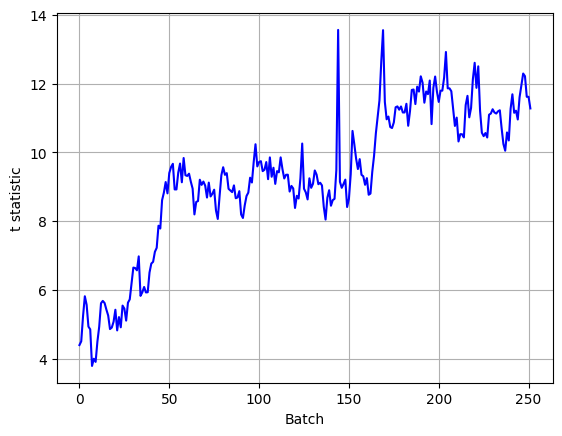

In [89]:

fig, ax = plt.subplots()
deltas, tstats, md = train_and_drift_insect("incremental")

ax.plot(tstats, c='b')
ax.set_xlabel("Batch")
ax.set_ylabel("t statistic")
ax.grid()